In [1]:
import polars as pl


fq_stat: pl.DataFrame = (pl.read_csv('/mnt/eqa/zhangyuanfeng/methylation/evaluated/fq_stat.csv',
                                     schema={'file': pl.String, 'format': pl.String,  'type': pl.String,
                                             'num_seqs': pl.Int64, 'sum_len': pl.Int64, 'min_len': pl.Int64,
                                             'avg_len': pl.Float64, 'max_len': pl.Int64, 'Q1': pl.Int64, 'Q2': pl.Int64,
                                             'Q3': pl.Int64, 'sum_gap': pl.Int64, 'N50': pl.Int64, 'N50_num': pl.Int64,
                                             'Q20(%)': pl.Float64, 'Q30(%)': pl.Float64, 'AvgQual': pl.Float64,
                                             'GC(%)': pl.Float64, 'sum_n': pl.Int64})
                           .with_columns(pl.col('file').str.slice(offset=0, length=8).alias('fname'))
                           .group_by('fname')
                           .agg(pl.col('sum_len').sum().alias('sum_len'))
                           .sort(by=['fname'])
                           .select('fname', 'sum_len'))
depth_stat = pl.read_excel('/mnt/eqa/zhangyuanfeng/methylation/evaluated/chrom_stats.xlsx',
                           sheet_name='chrom_counts')
chrom_stat = pl.read_excel('/mnt/eqa/zhangyuanfeng/methylation/evaluated/chrom_stats.xlsx',
                           sheet_name='chrom_depth_counts')


In [2]:
depth_stat

lab,label,rep,count_type,fname,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,chr11,chr12,chr13,chr14,chr15,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrX,chrY,chrM,lambda,pUC19,pipeline,total_with_wrong,total,wrong
str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64
"""BS1""","""BC""","""1""","""reads""","""BS1_BC_1""",51512144,39049254,36995393,29966526,34423518,28042105,46548834,29828597,24212849,26804857,23001958,23195948,14902575,23083051,20217489,28739663,22146727,17240248,18595687,18508298,9536262,17580409,15550545,1201486,106736,761185,36419,"""best_pipeline""",601788763,600587277,1201486
"""BS1""","""BC""","""1""","""cytosine""","""BS1_BC_1""",4685840,4296304,3313069,2957693,3083191,2918008,3219411,2620271,2470205,2740084,2616322,2591828,1550119,1757950,1786682,2284444,2378872,1471416,2151504,1534475,876511,1234134,2528195,139118,870,6225,346,"""best_pipeline""",57213087,57073969,139118
"""BS1""","""BC""","""1""","""reads""","""BS1_BC_1""",51921470,40418670,37537951,31310140,34464524,28501234,45344300,30029001,22980075,27076830,22839239,23221579,15031290,23299049,19988571,32684327,23280571,14951076,17379747,17963147,7362397,17315422,13607231,877898,2081927,10230463,113653,"""informed""",611811782,610933884,877898
"""BS1""","""BC""","""1""","""cytosine""","""BS1_BC_1""",4493546,4228097,3233320,2888398,2946875,2858690,3080432,2523258,2337288,2670142,2549351,2538836,1495732,1697224,1670845,2141706,2297395,1347863,2061499,1472476,744980,1155348,2200541,19658,864,6226,346,"""informed""",54660936,54641278,19658
"""BS1""","""BC""","""2""","""reads""","""BS1_BC_2""",47824913,37685576,36061924,30346142,33564630,27339289,44376130,28621175,23152410,25254215,21468927,22158844,14837469,21856600,18849290,25734254,19283751,17487709,15797925,17175204,9293931,15296186,15428264,1058893,105113,745230,35637,"""best_pipeline""",570839631,569780738,1058893
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""RR1""","""T4""","""2""","""reads""","""RR1_T4_2""",8493337,6580537,4805638,4215368,4380065,4490168,5506619,3888165,4403792,4545850,4773927,4553927,2228459,3035449,2959344,4954498,5958569,1953664,6936141,3109093,2236321,2988866,2906052,481446,168505,17094863,374747,"""agnostic""",118023410,100072354,17951056
"""RR1""","""T4""","""2""","""cytosine""","""RR1_T4_2""",766808,575248,402858,366936,385637,385864,491863,341544,400513,397991,414209,389313,199515,262503,267379,435570,507103,171718,575918,251885,156817,259270,309582,36418,129,3494,96,"""best_pipeline""",8756181,8716173,40008
"""RR1""","""T4""","""2""","""reads""","""RR1_T4_2""",10788968,7602048,5394478,5138067,5120810,5159250,6456549,4591466,5184513,5705530,5589655,5359833,2636428,3452071,3534669,5650244,6769132,2289973,7822013,3366709,3440639,3333218,3936717,395786,8667,402309,8167,"""best_pipeline""",119137909,118331647,806262


In [4]:
depth_dict_list = []
for fname in (depth_stat.filter(pl.col('count_type') == 'reads',
                                pl.col('pipeline') == 'informed')['fname'].unique()):
    chroms = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrM']
    total: int | float = (depth_stat.filter(pl.col('count_type') == 'reads',
                                            pl.col('pipeline') == 'informed',
                                            pl.col('fname') == fname)
                                    ['total'].first())
    depth_dict_list.append({'fname': fname, 'total_depth': total})


depth_efficiency: pl.DataFrame = (pl.DataFrame(depth_dict_list)
                                    .join(other=fq_stat, on='fname', how='inner')
                                    .with_columns((1000 * pl.col('total_depth') / pl.col('sum_len')).alias('depth_efficiency'),
                                                  pl.col('fname').str.head(3).alias('lab'),
                                                  pl.col('fname').str.slice(offset=4,
                                                                            length=2).alias('label'),
                                                  pl.col('fname').str.tail(n=1).alias('rep'))
                                    .rename({'sum_len': 'total_bases'})
                                    .select('lab', 'label', 'rep', 'fname', 'total_depth',
                                            'total_bases', 'depth_efficiency')
                                    .sort(by=['lab', 'label', 'rep']))
depth_efficiency

lab,label,rep,fname,total_depth,total_bases,depth_efficiency
str,str,str,str,i64,i64,f64
"""BS1""","""BC""","""1""","""BS1_BC_1""",610933884,54040177350,11.305179
"""BS1""","""BC""","""2""","""BS1_BC_2""",580696075,56411283450,10.29397
"""BS1""","""BL""","""1""","""BS1_BL_1""",619893872,53765509650,11.529582
"""BS1""","""BL""","""2""","""BS1_BL_2""",587019336,51372176250,11.426795
"""BS1""","""D5""","""1""","""BS1_D5_1""",575165929,55670357850,10.331637
…,…,…,…,…,…,…
"""RR1""","""T2""","""2""","""RR1_T2_2""",181223824,4495763506,40.30991
"""RR1""","""T3""","""1""","""RR1_T3_1""",182320245,4262106112,42.777031
"""RR1""","""T3""","""2""","""RR1_T3_2""",204480880,4810530952,42.506925


In [6]:
depth_efficiency.write_csv('/mnt/eqa/zhangyuanfeng/methylation/data_for_plot/1_data_quality_snr/depth_efficiency.csv')

In [7]:
cytosine_dict_list = []
for fname in (depth_stat.filter(pl.col('count_type') == 'cytosine',
                                   pl.col('pipeline') == 'informed')['fname'].unique()):
    total: int | float = (depth_stat.filter(pl.col('count_type') == 'cytosine',
                                            pl.col('pipeline') == 'informed',
                                            pl.col('fname') == fname)
                                    ['total'].first())
    cytosine_dict_list.append({'fname': fname, 'total_cytosines': total})


cytosine_efficiency: pl.DataFrame = (pl.DataFrame(cytosine_dict_list)
                                       .join(other=fq_stat, on='fname', how='inner')
                                       .with_columns((10000 * pl.col('total_cytosines') / pl.col('sum_len')).alias('cytosine_efficiency'),
                                                      pl.col('fname').str.head(3).alias('lab'),
                                                      pl.col('fname').str.slice(offset=4,
                                                                                length=2).alias('label'),
                                                      pl.col('fname').str.tail(n=1).alias('rep'))
                                       .rename({'sum_len': 'total_bases'})
                                       .select('lab', 'label', 'rep', 'fname', 'total_cytosines',
                                               'total_bases', 'cytosine_efficiency')
                                       .sort(by=['lab', 'label', 'rep']))
cytosine_efficiency

lab,label,rep,fname,total_cytosines,total_bases,cytosine_efficiency
str,str,str,str,i64,i64,f64
"""BS1""","""BC""","""1""","""BS1_BC_1""",54641278,54040177350,10.111232
"""BS1""","""BC""","""2""","""BS1_BC_2""",54428472,56411283450,9.648508
"""BS1""","""BL""","""1""","""BS1_BL_1""",55081153,53765509650,10.2447
"""BS1""","""BL""","""2""","""BS1_BL_2""",54999523,51372176250,10.706092
"""BS1""","""D5""","""1""","""BS1_D5_1""",54282667,55670357850,9.750731
…,…,…,…,…,…,…
"""RR1""","""T2""","""2""","""RR1_T2_2""",8369190,4495763506,18.615726
"""RR1""","""T3""","""1""","""RR1_T3_1""",6192331,4262106112,14.528805
"""RR1""","""T3""","""2""","""RR1_T3_2""",8799089,4810530952,18.291305


In [8]:
cytosine_efficiency.write_csv('/mnt/eqa/zhangyuanfeng/methylation/data_for_plot/1_data_quality_snr/cytosine_efficiency.csv')

<Axes: xlabel='lab', ylabel='depth_efficiency'>

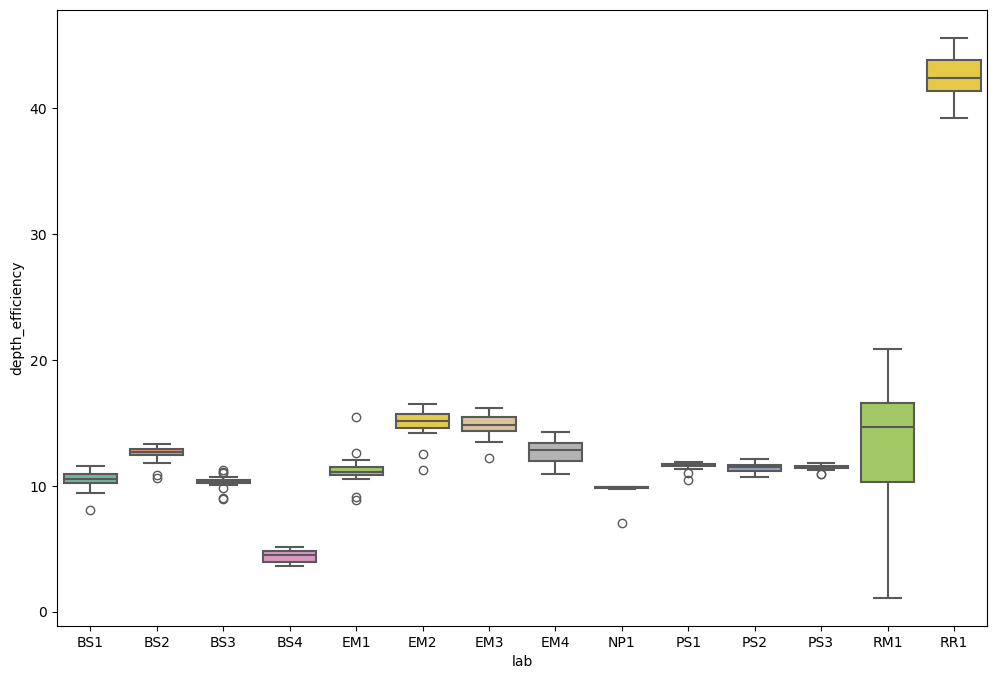

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns


fig = plt.figure(figsize=(12, 8))
sns.boxplot(data=depth_efficiency.to_pandas(),
            x='lab', y='depth_efficiency', hue='lab', palette='Set2', linewidth=1.5)

<Axes: xlabel='lab', ylabel='cytosine_efficiency'>

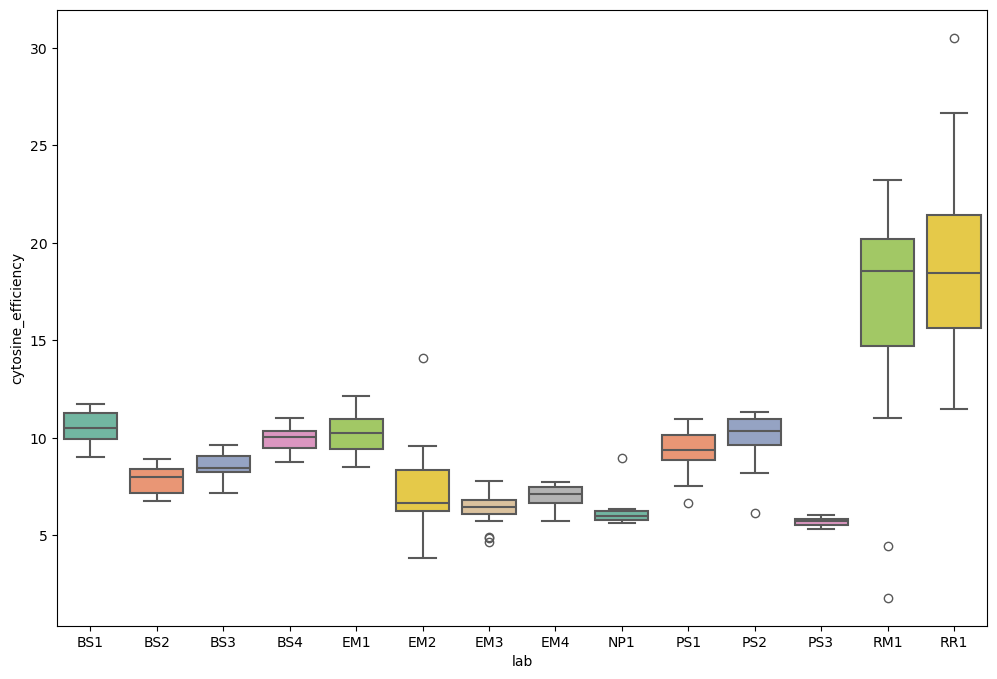

In [10]:
fig = plt.figure(figsize=(12, 8))
sns.boxplot(data=cytosine_efficiency.to_pandas(),
            x='lab', y='cytosine_efficiency', hue='lab', palette='Set2', linewidth=1.5)

In [12]:
chrom_sum_dict_list = []

for fname in (chrom_stat.filter(pl.col('count_type') == 'cytosine',
                                pl.col('pipeline') == 'informed')['fname'].unique()):
    chroms = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrM']

    if 'F7' in fname or 'HF' in fname:
        chroms += ['chrY']

    if 'RR' not in fname and 'HF' not in fname:
        chroms += ['lambda', 'pUC19']

    fname_df: pl.DataFrame = (chrom_stat.filter(pl.col('count_type') == 'cytosine',
                                                pl.col('pipeline') == 'informed',
                                                pl.col('fname') == fname,
                                                pl.col('chrom').is_in(chroms))
)
    for depth_bin in chrom_stat['depth_bin'].unique():
        total: int
        if fname_df.filter(pl.col('depth_bin') == depth_bin).is_empty():
            total = 0
        else:
            total = (fname_df.filter(pl.col('depth_bin') == depth_bin)['count'].sum())
        chrom_sum_dict_list.append({
            'fname': fname, 'depth_bin': depth_bin, 'cytosines': total
        })


depth_cytosine_efficiency = (pl.DataFrame(chrom_sum_dict_list)
                               .with_columns(pl.col('fname').str.head(3).alias('lab'),
                                             pl.col('fname').str.slice(offset=4,
                                                                       length=2).alias('label'),
                                             pl.col('fname').str.tail(n=1).alias('rep'))
                               .select('lab', 'label', 'rep', 'depth_bin', 'cytosines'))
depth_cytosine_efficiency


lab,label,rep,depth_bin,cytosines
str,str,str,str,i64
"""BS3""","""T3""","""1""","""4x""",2673493
"""BS3""","""T3""","""1""","""5–10x""",20865257
"""BS3""","""T3""","""1""","""≥60x""",34639
"""BS3""","""T3""","""1""","""3x""",2012587
"""BS3""","""T3""","""1""","""10–20x""",23967121
…,…,…,…,…
"""BS4""","""BL""","""2""","""50–60x""",4844
"""BS4""","""BL""","""2""","""20–30x""",47814
"""BS4""","""BL""","""2""","""5–10x""",10705081


In [13]:
depth_cytosine_efficiency.write_csv('/mnt/eqa/zhangyuanfeng/methylation/data_for_plot/1_data_quality_snr/depth_cytosine_efficiency.csv')

In [19]:
percent_stat: pl.DataFrame

percent_stat = (depth_cytosine_efficiency
                .pivot(on='depth_bin',
                       index=['lab', 'label', 'rep'],
                       values='cytosines')
                .with_columns(pl.sum_horizontal('1x', '2x', '3x', '4x',
                                                '5–10x', '10–20x',
                                                '20–30x', '30–40x',
                                                '40–50x', '50–60x',
                                                '≥60x')
                                .alias('total'))
                .with_columns((pl.sum_horizontal('5–10x', '10–20x',
                                                 '20–30x', '30–40x',
                                                 '40–50x', '50–60x',
                                                 '≥60x') * 100 / pl.col('total'))
                                .alias('≥5x%'),
                              (pl.sum_horizontal('10–20x', '20–30x',
                                                 '30–40x', '40–50x',
                                                 '50–60x', '≥60x') * 100 / pl.col('total'))
                                .alias('≥10x%'))
                .select('lab', 'label', 'rep', '≥5x%', '≥10x%')
                .sort(by=['lab', 'label', 'rep'])
                )
percent_stat

lab,label,rep,≥5x%,≥10x%
str,str,str,f64,f64
"""BS1""","""BC""","""1""",78.84302,43.30167
"""BS1""","""BC""","""2""",73.022662,38.79092
"""BS1""","""BL""","""1""",83.990811,46.36178
"""BS1""","""BL""","""2""",81.196031,42.553853
"""BS1""","""D5""","""1""",75.784523,42.475024
…,…,…,…,…
"""RR1""","""T2""","""2""",71.091969,57.888625
"""RR1""","""T3""","""1""",76.2025,66.960019
"""RR1""","""T3""","""2""",70.361614,59.207288


In [20]:
percent_stat.write_csv('/mnt/eqa/zhangyuanfeng/methylation/data_for_plot/1_data_quality_snr/depth_5_10_percent.csv')